In [48]:
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset, load_dataset_builder
import torchvision.transforms.functional as TF
import numpy as np

In [167]:
name = 'fashion_mnist'
dsd = load_dataset(name)
x,y = 'image', 'label'

Found cached dataset fashion_mnist (/Users/arun/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [168]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [169]:
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f
     
@inplace
def transformi_(b):
    b[x] = [torch.flatten(TF.to_tensor(ele)) for ele in b[x]] 

In [170]:
bs = 1024
tds = dsd.with_transform(transformi_)

In [172]:
tds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [155]:
from operator import itemgetter
from torch.utils.data import default_collate, DataLoader

def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

class DataLoaders:
    def __init__(self, *dls):
        self.train, self.valid = dls[:2]
    
    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))

In [176]:
dls = DataLoaders.from_dd(tds, batch_size=bs)
dt = dls.train
xb, yb = next(iter(dt))

(<matplotlib.image.AxesImage at 0x17f4fc350>, tensor(9))

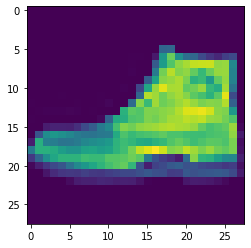

In [197]:
plt.imshow(xb[1].view(28, 28)), yb[1]

In [202]:
import fastcore.all as fc
import torch.optim as optim

class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD):
        fc.store_attr()
    
    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)
    
    def one_batch(self):
        self.xb,self.yb = self.batch
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad():
            self.calc_stats()
    
    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(dl):
            self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
    
    def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), lr=self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(self.n_epochs):
            self.one_epoch(True)
            with torch.no_grad():
                self.one_epoch(False)